<a href="https://colab.research.google.com/github/choton654/Local-Retrieval-Augmented-Generation-RAG-from-Scratch/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install requests
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash-attn


Import PDF

In [ ]:
import os
import requests

pdf_path = 'human_nutration.pdf'

# Download pdf
if not os.path.exists(pdf_path):
  print("[INFO] file does not exist downloading...")

  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  filename = pdf_path

  # GET the file from the url
  response = requests.get(url)

  if response.status_code == 200:
    # open the file and save it
    with open(filename, 'wb') as file:
      file.write(response.content)
    print(f"[INFO] the file has beed downloaded and save as {filename}")
  else:
    print(f"Failed to download the file, Status code {response.status_code}")
else:
  print(f"File {pdf_path} exists")

[INFO] file does not exist downloading...
[INFO] the file has beed downloaded and save as human_nutration.pdf


Open the pdf

In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text


def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_texts.append({
        "page_number":page_number - 41,
        "page_char_count":len(text),
        "page_word_count":len(text.split(" ")),
        "page_sentence_count_raw":len(text.split(". ")),
        "page_token_count":len(text) / 4,
        "text":text
    })

  return pages_and_texts

pages_and_texts=open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 78,
  'page_char_count': 1325,
  'page_word_count': 228,
  'page_sentence_count_raw': 10,
  'page_token_count': 331.25,
  'text': 'Nutrients Are Essential for Cell and Organ  Function  When the digestive system has broken down food to its nutrient  components, the body eagerly awaits delivery. Water soluble  nutrients absorbed into the blood travel directly to the liver via a  major blood vessel called the portal vein. One of the liver’s primary  functions is to regulate metabolic homeostasis. Metabolic  homeostasis is achieved when the nutrients consumed and  absorbed match the energy required to carry out life’s biological  processes. Simply put, nutrient energy intake equals energy output.  Whereas glucose and amino acids are directly transported from  the small intestine to the liver, lipids are transported to the liver  by a more circuitous route involving the lymphatic system. The  lymphatic system is a one-way system of vessels that transports  lymph, a fluid ri

In [ ]:
import pandas as pd

x = pd.DataFrame(pages_and_texts)
x.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df = x
df.describe().round()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.0,1208.0,1208.0,1208.0,1208.0
mean,562.0,1148.0,198.0,10.0,287.0
std,349.0,560.0,96.0,6.0,140.0
min,-41.0,0.0,1.0,1.0,0.0
25%,261.0,762.0,134.0,4.0,190.0
50%,562.0,1232.0,214.0,10.0,308.0
75%,864.0,1604.0,271.0,14.0,401.0
max,1166.0,2308.0,429.0,32.0,577.0


In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")
doc = nlp("This is a sentence. This is another sentence. I love cats")
assert len(list(doc.sents)) == 3

list(doc.sents)


[This is a sentence., This is another sentence., I love cats]

In [ ]:
for item in tqdm(pages_and_texts):
  item['sentences'] = list(nlp(item['text']).sents)

  # Make sure all sentences are strings, the default type is spacy datatype
  item['sentences'] = [str(sentence) for sentence in item['sentences']]

  item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 557,
  'page_char_count': 1372,
  'page_word_count': 292,
  'page_sentence_count_raw': 20,
  'page_token_count': 343.0,
  'text': 'Dietary Sources of Vitamin C  Citrus fruits are great sources of vitamin C and so are many  vegetables. In fact, British sailors in the past were often referred  to as “limeys” as they carried sacks of limes onto ships to prevent  scurvy. Vitamin C is not found in significant amounts in animal- based foods.  Because vitamin C is water-soluble, it leaches away from foods  considerably during cooking, freezing, thawing, and canning. Up to  50 percent of vitamin C can be boiled away. Therefore, to maximize  vitamin C intake from foods, you should eat fruits and vegetables  raw or lightly steamed. For the vitamin C content of various foods,  see Table 9.12 “Vitamin C Content of Various Foods”.  Table 9.12 Vitamin C Content of Various Foods  Food  Serving  Vitamin C  (mg)  Percent Daily  Value  Orange juice  6 oz.  93  155  Grapefruit juice  6 o

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0
mean,562.0,1148.0,198.0,10.0,287.0,10.0
std,349.0,560.0,96.0,6.0,140.0,6.0
min,-41.0,0.0,1.0,1.0,0.0,0.0
25%,261.0,762.0,134.0,4.0,190.0,5.0
50%,562.0,1232.0,214.0,10.0,308.0,10.0
75%,864.0,1604.0,271.0,14.0,401.0,15.0
max,1166.0,2308.0,429.0,32.0,577.0,28.0


In [ ]:
# Define split size to turn group of sentences into chunks

num_sentence_chunk_size = 10

#  create a function to split a list into desire sizes
def split_list(input_list:list, split_size: int=num_sentence_chunk_size) -> list[list[str]]:
  return [input_list[i:i+split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
from tqdm.auto import tqdm

for item in tqdm(pages_and_texts):
  item['sentence_chunks'] = split_list(input_list=item['sentences'], split_size=num_sentence_chunk_size)
  item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0
mean,562.0,1148.0,198.0,10.0,287.0,10.0,2.0
std,349.0,560.0,96.0,6.0,140.0,6.0,1.0
min,-41.0,0.0,1.0,1.0,0.0,0.0,0.0
25%,261.0,762.0,134.0,4.0,190.0,5.0,1.0
50%,562.0,1232.0,214.0,10.0,308.0,10.0,1.0
75%,864.0,1604.0,271.0,14.0,401.0,15.0,2.0
max,1166.0,2308.0,429.0,32.0,577.0,28.0,3.0


In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 40,
  'page_char_count': 440,
  'page_word_count': 65,
  'page_sentence_count_raw': 3,
  'page_token_count': 110.0,
  'text': 'http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=61  An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=61  An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=61  \xa0 40  |  Research and the Scientific Method',
  'sentences': ['http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=61  An interactive or media element has been  excluded from this version of the text.',
   'You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=61  An interactive or media element has been  excluded from this version of the text.',
   'You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannu

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item['sentence_chunks']:
    chunk_dict = {}
    chunk_dict['page_number'] = item['page_number']

    # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
    join_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
    join_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', join_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo

    chunk_dict['sentence_chunk'] = join_sentence_chunk
    chunk_dict['chunk_char_count'] = len(join_sentence_chunk)
    chunk_dict['chunk_word_count'] = len([word for word in join_sentence_chunk.split(" ")])
    chunk_dict['chunk_token_count'] = len(join_sentence_chunk) / 4

    pages_and_chunks.append(chunk_dict)


len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 196,
  'sentence_chunk': 'Potassium also is involved in protein synthesis, energy metabolism,  and platelet function, and acts as a buffer in blood, playing a role in  acid-base balance. Imbalances of Potassium  Insufficient potassium levels in the body (hypokalemia) can be  caused by a low dietary intake of potassium or by high sodium  intakes, but more commonly it results from medications that  increase water excretion, mainly diuretics. The signs and symptoms  of hypokalemia are related to the functions of potassium in nerve  cells and consequently skeletal and smooth-muscle contraction. The signs and symptoms include muscle weakness and cramps,  respiratory distress, and constipation. Severe potassium depletion  can cause the heart to have abnormal contractions and can even  be fatal. High levels of potassium in the blood, or hyperkalemia,  also affects the heart. It is a silent condition as it often displays  no signs or symptoms. Extremely high levels of potassiu

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round()

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.0,1843.0,1843.0,1843.0
mean,583.0,750.0,128.0,188.0
std,348.0,456.0,80.0,114.0
min,-41.0,14.0,4.0,4.0
25%,280.0,322.0,51.0,80.0
50%,586.0,763.0,131.0,191.0
75%,890.0,1138.0,194.0,284.0
max,1166.0,1870.0,412.0,468.0


In [ ]:
# Show random chunks with under 30 tokens in length
min_token_len = 30
for row in df[df['chunk_token_count'] <= min_token_len].sample(5).iterrows():
  print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 29.5 | Text: The World Bank claims that a million  deaths occur every year from anemia and that the majority of those  Iron  |  663
Chunk token count: 21.75 | Text: PART III  CHAPTER 3. WATER AND  ELECTROLYTES  Chapter 3. Water and Electrolytes  |  143
Chunk token count: 17.0 | Text: Complementary foods include baby meats, vegetables,  Infancy  |  837
Chunk token count: 27.5 | Text: It  is stored in the rectum until it is expelled through the anus via  defecation. The Digestive System  |  77
Chunk token count: 14.75 | Text: http://www.fao.org/3/ca5162en/ca5162en.pdf  822  |  Infancy


In [ ]:
# filter smaller chunks
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_len].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

In [ ]:
from sentence_transformers import SentenceTransformer

embeding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device='cpu')

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embeding_model.encode(sentences)
embedding_dict = dict(zip(sentences, embeddings))

for sentences, embeddings in embedding_dict.items():
  print("sentences",sentences)
  print("embeddings",embeddings)
  print(" ")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

sentences The Sentences Transformers library provides an easy and open-source way to create embeddings.
embeddings [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [ ]:
embeddings.shape

(768,)

In [ ]:
embedding = embeding_model.encode("My favourite animal is cow !")
embedding

array([-1.96209662e-02,  8.38151053e-02, -2.69791242e-02, -2.71897968e-02,
        5.65179177e-02,  3.30238082e-02, -6.96982890e-02,  2.64591388e-02,
        3.23011167e-02, -2.43504681e-02, -5.19218780e-02,  3.46663669e-02,
       -3.56558040e-02,  1.47935040e-02, -2.15756949e-02, -3.23066935e-02,
        3.88272926e-02, -9.08350945e-03,  4.83997952e-04,  4.48481180e-02,
       -2.02360023e-02,  4.03421447e-02, -1.84171945e-02, -1.81342717e-02,
       -1.97995640e-02,  6.61884015e-03, -2.21398678e-02, -3.31439413e-02,
        2.51131747e-02,  2.25845724e-02, -5.38325869e-02, -7.31923431e-02,
        2.99765263e-02, -4.97894781e-03,  1.26364978e-06, -8.09536222e-03,
       -3.33836712e-02,  1.79500468e-02,  3.55832726e-02,  2.76250276e-03,
        1.52193021e-03,  8.47014715e-04, -7.71485921e-03,  2.17913068e-03,
        2.11219769e-02,  5.47550470e-02,  4.26250286e-02,  3.47682112e-03,
       -7.95056745e-02,  2.18655057e-02, -8.07488710e-03, -1.49295274e-02,
       -3.38713489e-02, -

In [ ]:
%%time

embeding_model.to('cpu')

for item in tqdm(pages_and_chunks_over_min_token_len):
  item['embeddings'] = embeding_model.encode(item['sentence_chunk'])

  0%|          | 0/1685 [00:00<?, ?it/s]

CPU times: user 22min 2s, sys: 5.91 s, total: 22min 8s
Wall time: 22min 22s


In [ ]:
# %%time

# # check on gpu
# embeding_model.to('cuda')

# for item in tqdm(pages_and_chunks_over_min_token_len):
#   item['embeddings'] = embeding_model.encode(item['sentence_chunk'])

In [ ]:
# Turn text chunks into a single list
text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]

len(text_chunks)

1685

In [ ]:
# %%time

# # Embed all texts in batches
# text_chunk_embeddings = embeding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

# text_chunk_embeddings

In [ ]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 276,
 'sentence_chunk': 'Personal Choices  Carbohydrates are in most foods so you have a great variety of  choices with which to meet the carbohydrates recommendations  for a healthy diet. The 2010 Dietary Guidelines recommends eating  more unrefined carbohydrates and more fiber, and reducing  consumption of foods that are high in added sugars. To accomplish  these recommendations use some or all of the following  suggestions:  • Get more daily carbohydrate servings from whole grains by  eating a whole-grain cereal for breakfast, using whole-grain  bread to make a sandwich for lunch, and eating a serving of  beans and/or nuts with dinner. • Make sure to get at least three servings (or more) of all the  grains you eat as whole grains every day. A serving of whole  grains is equal to one slice of whole-wheat bread, one ounce of  whole-grain cereal, and one-half cup of cooked cereal, brown  rice, or whole-wheat pasta. Food products made with cornmeal use the whole grain so

In [ ]:
# Save embeddings to file
text_chunk_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunk_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# load and vew csv
text_chunk_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunk_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242601e-02 9.02279988e-02 -5.09551819e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156493e-02 5.92137985e-02 -1.66167784e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,[ 2.79801469e-02 3.39813307e-02 -2.06427258e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,[ 6.82566613e-02 3.81274484e-02 -8.46858509e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264196e-02 -8.49771872e-03 9.57152341e-...


In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

text_chunk_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunk_embeddings_df['embeddings'] = text_chunk_embeddings_df['embeddings'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.stack(text_chunk_embeddings_df['embeddings'].to_list(), axis=0), dtype=torch.float32)

pages_and_chunks = text_chunk_embeddings_df.to_dict(orient='records')

text_chunk_embeddings_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[0.0674242601, 0.0902279988, -0.00509551819, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.0552156493, 0.0592137985, -0.0166167784, -0..."
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,"[0.0279801469, 0.0339813307, -0.0206427258, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,"[0.0682566613, 0.0381274484, -0.00846858509, -..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[0.0330264196, -0.00849771872, 0.00957152341, ..."


In [ ]:
embeddings.shape

torch.Size([1685, 768])

In [ ]:
device

'cpu'

In [ ]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1677e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1828e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8009e-02,  2.2295e-02,  5.6136e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6370e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4898e-04, -9.9662e-02,  4.9

In [ ]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2', device=device)

Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:

Define a query string (e.g. "macronutrients functions") - note: this could be anything, specific or not.
Turn the query string in an embedding with same model we used to embed our text chunks.
Perform a dot product or cosine similarity function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

In [ ]:
# 1. Define the query
query = 'good foods for protein'
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query, convert_to_tensor=True)


# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top K results
top_results_dot_products = torch.topk(dot_scores, k=5)
top_results_dot_products

Query: good foods for protein
Time take to get scores on 1685 embeddings: 0.00131 seconds.


torch.return_types.topk(
values=tensor([0.7729, 0.7647, 0.6743, 0.6743, 0.6634]),
indices=tensor([614, 619, 618, 623, 620]))

In [ ]:
pages_and_chunks[1155]

{'page_number': 816,
 'sentence_chunk': 'milk is the best source to fulfill nutritional requirements. An  exclusively breastfed infant does not even need extra water,  including in hot climates. A newborn infant (birth to 28 days) requires feedings eight to  twelve times a day or more. Between 1 and 3 months of age, the  breastfed infant becomes more efficient, and the number of  feedings per day often become fewer even though the amount of  milk consumed stays the same. After about six months, infants can  gradually begin to consume solid foods to help meet nutrient needs. Foods that are added in addition to breastmilk are called  complementary foods. Complementary foods should be nutrient  dense to provide optimal nutrition. Complementary foods include  baby meats, vegetables, fruits, infant cereal, and dairy products such  as yogurt, but not infant formula. Infant formula is a substitute, not  a complement to breastmilk. In addition to complementary foods,  the World Health Organiza

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168500, 768])
Time take to get scores on 168500 embeddings: 0.06993 seconds.


In [ ]:
top_results_dot_products[0], top_results_dot_products[1]

(tensor([0.6749, 0.6574, 0.6543, 0.6354, 0.6168]),
 tensor([1155, 1173, 1164, 1148, 1142]))

In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrapped_length=80):
  wrapped_text = textwrap.fill(text, wrapped_length)
  print(wrapped_text)

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")

# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_products[0], top_results_dot_products[1]):
  print(f"Score, {score:.4f}")
  # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
  print("Text:")
  print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
  # Print the page number too so we can reference the textbook further (and check the results)
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'good foods for protein'

Results:
Score, 0.7729
Text:
Dietary Sources of Protein  The protein food group consists of foods made from
meat, seafood,  poultry, eggs, soy, dry beans, peas, and seeds. According to the
Harvard School of Public Health, “animal protein and vegetable  protein probably
have the same effects on health. It’s the protein  package that’s likely to make
a difference.”1  1. Protein: The Bottom Line. Harvard School of Public
Proteins, Diet, and Personal Choices  |  411
Page number: 411


Score, 0.7647
Text:
Additionally, a person should consume 8 ounces of cooked seafood  every week
(typically as two 4-ounce servings) to assure they are  getting the healthy
omega-3 fatty acids that have been linked to a  lower risk for heart disease.
Another tip is choosing to eat dry beans,  peas, or soy products as a main dish.
Some of the menu choices  include chili with kidney and pinto beans, hummus on
pita bread,  and black bean enchiladas. You could also enjoy nuts in a

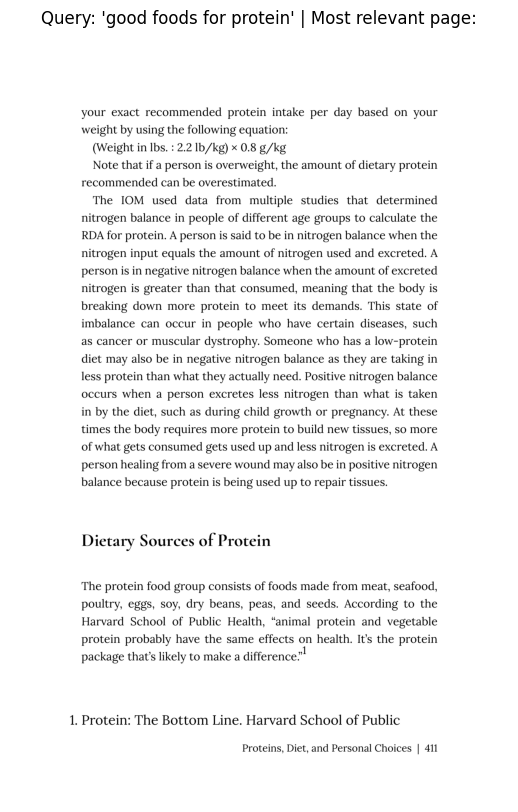

In [ ]:
import fitz

pdf_path = 'human_nutration.pdf'

doc = fitz.open(pdf_path)
page = doc.load_page(411 + 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()


In [2]:
import torch

def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
  dot_product = torch.dot(vector1, vector2)

  # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
  norm_vector1 = torch.sqrt(torch.sum(vector1**2))
  norm_vecto21 = torch.sqrt(torch.sum(vector2**2))

  return dot_product / (norm_vector1 * norm_vecto21)


# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)
